# SVM参数调优on数据集Rent Listing Inqueries

我们以Kaggle2017年举办的Two Sigma Connect: Rental Listing Inquiries竞赛数据为例进行数据集探索分析。
可以参考kernel中更多数据分析示例：https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/kernels
竞赛官网：https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data

下面的代码是照搬FE_RentListingInqueries.ipynb

亦可直接读取特征编码后的文件，则代码与课堂示例代码完全相同

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

#竞赛的评价指标为logloss
from sklearn.metrics import log_loss  
#SVM并不能直接输出各类的概率，
#所以在这个例子中我们用正确率作为模型预测性能的度量，SVM并不适合用于这个任务
from sklearn.metrics import accuracy_score

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据 & 数据探索

In [2]:
#input data
dpath = './data/'
train = pd.read_json(dpath +"RentListingInquries_train.json")

## 特征编码

In [3]:
y_map = {'low': 2, 'medium': 1, 'high': 0}
train['interest_level'] = train['interest_level'].apply(lambda x: y_map[x])

## 数据预处理

In [4]:
#remove some noise
train= train[train.price < 10000]

train.loc[train["bathrooms"] == 112, "bathrooms"] = 1.5
train.loc[train["bathrooms"] == 10, "bathrooms"] = 1
train.loc[train["bathrooms"] == 20, "bathrooms"] = 2

In [5]:
y_train = train['interest_level']
train.drop(["interest_level"], axis=1, inplace=True)

In [6]:
#manager_id
managers_count = train['manager_id'].value_counts()

train['top_10_manager'] = train['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 90)] else 0)
train['top_25_manager'] = train['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 75)] else 0)
train['top_5_manager'] = train['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 95)] else 0)
train['top_50_manager'] = train['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 50)] else 0)
train['top_1_manager'] = train['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 99)] else 0)
train['top_2_manager'] = train['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 98)] else 0)
train['top_15_manager'] = train['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 85)] else 0)
train['top_20_manager'] = train['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 80)] else 0)
train['top_30_manager'] = train['manager_id'].apply(lambda x: 1 if x in managers_count.index.values[
    managers_count.values >= np.percentile(managers_count.values, 70)] else 0)

In [7]:
## latitude, longtitude
#聚类降维编码
# Clustering
from sklearn.cluster import KMeans
from nltk.metrics import distance as distance

train_location = train[ ['latitude', 'longitude']]

kmeans_cluster = KMeans(n_clusters=20)
res = kmeans_cluster.fit(train_location)
train['cenroid'] = res

# L1 distance
center = [ train_location['latitude'].mean(), train_location['longitude'].mean()]
train['distance'] = abs(train['latitude'] - center[0]) + abs(train['longitude'] - center[1])

In [8]:
#对地理聚类中心进行编码
#from MeanEncoder import MeanEncoder
#me = MeanEncoder('cenroid')
#cenroid_cat = me.fit_transform(train, y_train)

#cenroid_cat = pd.get_dummies(train['cenroid'])

In [9]:
train = train.drop(["cenroid","listing_id","photos","features","building_id","created","description","display_address","street_address","manager_id"], axis=1)

In [10]:
train = train.drop(["latitude","longitude"], axis=1)

In [11]:
train.head()

,bathrooms,bedrooms,price,top_10_manager,top_25_manager,top_5_manager,top_50_manager,top_1_manager,top_2_manager,top_15_manager,top_20_manager,top_30_manager,distance
10,1.5,3,3000,1,1,1,1,0,0,1,1,1,0.041378
10000,1.0,2,5465,1,1,1,1,0,0,1,1,1,0.063022
100004,1.0,1,2850,1,1,1,1,0,1,1,1,1,0.048436
100007,1.0,1,3275,1,1,1,1,1,1,1,1,1,0.023222
100013,1.0,4,3350,0,1,0,1,0,0,0,0,1,0.089364


In [12]:
X_train = train

In [13]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 初始化特征的标准化器
ss_X = StandardScaler()

# 分别对训练和测试数据的特征进行标准化处理
X_train = ss_X.fit_transform(X_train)
#X_test = ss_X.transform(X_test)


## 模型训练

In [14]:
# 训练样本6w+，交叉验证太慢，用train_test_split估计模型性能
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.33,random_state = 0)

/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### RBF核SVM正则参数调优

RBF核是SVM最常用的核函数。
RBF核SVM 的需要调整正则超参数包括C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和核函数的宽度gamma
C越小，决策边界越平滑； 
gamma越小，决策边界越平滑。

采用交叉验证，网格搜索步骤与Logistic回归正则参数处理类似，在此略。

这里我们用校验集（X_val、y_val）来估计模型性能

In [15]:
from sklearn.svm import SVC

In [16]:
def fit_grid_point_RBF(C, gamma, X_train, y_train, X_val, y_val):
    
    # 在训练集是那个利用SVC训练
    SVC3 =  SVC( C = C, kernel='rbf', gamma = gamma)
    SVC3 = SVC3.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC3.score(X_val, y_val)
    accuracy_train = SVC3.score(X_train, y_train)
    
    print("accuracy on test: %f and on train: %f with C = %f and gamma = %f"%(accuracy, accuracy_train, C, gamma) )
    return accuracy

In [17]:
#需要调优的参数
C_s = np.logspace(-2, 2, 5)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-2, 2, 5)  

accuracy_s = []
for i, oneC in enumerate(C_s):
    for j, gamma in enumerate(gamma_s):
        tmp = fit_grid_point_RBF(oneC, gamma, X_train_part, y_train_part, X_val, y_val)
        accuracy_s.append(tmp)


accuracy: 0.688747647404
accuracy: 0.688747647404
accuracy: 0.688747647404
accuracy: 0.688747647404
accuracy: 0.688747647404
accuracy: 0.688747647404
accuracy: 0.688747647404
accuracy: 0.688747647404
accuracy: 0.689241306964
accuracy: 0.689056184629
accuracy: 0.688747647404
accuracy: 0.688747647404
accuracy: 0.689734966524
accuracy: 0.691370213816
accuracy: 0.686618740551
accuracy: 0.688747647404
accuracy: 0.689056184629
accuracy: 0.689889235136
accuracy: 0.687420937336
accuracy: 0.674092129215
accuracy: 0.688747647404
accuracy: 0.690629724476
accuracy: 0.688284841566
accuracy: 0.683749344358
accuracy: 0.655363919657


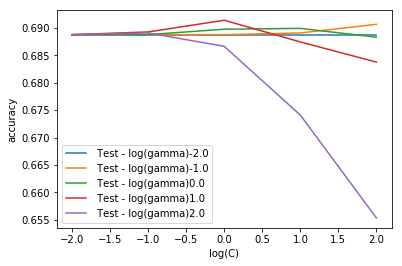

In [18]:
accuracy_s1 =np.array(accuracy_s).reshape(len(C_s),len(gamma_s))
x_axis = np.log10(C_s)
for j, gamma in enumerate(gamma_s):
    pyplot.plot(x_axis, np.array(accuracy_s1[:,j]), label = ' Test - log(gamma)' + str(np.log10(gamma)))

pyplot.legend()
pyplot.xlabel( 'log(C)' )                                                                                                      
pyplot.ylabel( 'accuracy' )
pyplot.savefig('RBF_SVM_Rent.png' )

pyplot.show()

C和gmma都为100时模型性能很低，此时可能已经过拟和
最佳参数：C=1，gamma=10


### 用最佳参数在全体训练数据上训练模型

In [ ]:
bestCs = accuracy_s1.argmax(axis = 0)

best_accuracy = logloss_s1[bestCs[0],0]
best_gamma_index = 0
best_gamma = penaltys[best_penalty_index]

for j, onePenalty in enumerate(penaltys):
    if logloss_s1[bestCs[j],j] < best_logloss:
        best_logloss = logloss_s1[bestCs[j],j]
        best_penalty_index = j
        best_penalty = penaltys[best_penalty_index]

bestC = Cs[bestCs[best_penalty_index]]

print("best C: %f \n best penalty: %s"%(bestC, best_penalty) )
    
LR = LogisticRegression(penalty=best_penalty, C=bestC)
LR.fit(X_train, y_train)

## 生成测试提交文件

略
SVM分类器的预测结果不方便得到每类的概率。所以如果评价标准是logloss这种需要输出概率的，首选不是SVM